In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

### Generating csv with energy prices in Spain

In [15]:
# Define the folder where all the files are located
folder_path = r'Data_Vyncke/Data_Share/marginalpdbc_2022'

# Define column names based on your data structure (excluding Year)
dataframes = []

for filename in os.listdir(folder_path):
    if filename.startswith('marginalpdbc_') and filename.endswith('.1'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_table(file_path, sep=';', skiprows=1, skipfooter=1, engine='python', header=None)
        df = df.iloc[:, :-1]
        dataframes.append(df)

combined_energy_prices = pd.concat(dataframes, ignore_index=True)
#print(combined_energy_prices)

### Formatting the date and time of the energy prices

In [ ]:
combined_energy_prices[3] = combined_energy_prices[3].apply(lambda x: '00' if x == 24 else str(x).zfill(2))
# one price is defined in 25:00 so we drop it
combined_energy_prices = combined_energy_prices[combined_energy_prices[3].astype(int) < 25]

# Converting the combined_energy_prices dates to a readable format
combined_energy_prices['datetime'] = pd.to_datetime(combined_energy_prices[[0,1,2,3]].astype(str).agg('-'.join, axis=1) + ':00')
#print(combined_energy_prices)
combined_energy_prices.drop(columns=[0,1,2,3], inplace=True)
# Rename the columns
combined_energy_prices.columns = ['price1', 'price2', 'datetime']
# Rearrange the columns to have 'datetime' first
combined_energy_prices = combined_energy_prices[['datetime', 'price1', 'price2']]
#print(combined_energy_prices)
#combined_energy_prices.to_csv('Data_Vyncke/Data_Share/combined_energy_prices.csv', index=False)


### Loading the main dataset and removing duplicates

In [17]:
# Load main dataset
data = pd.read_csv('Data_Vyncke\Data_Share\Data_WTE.csv')
data = data.drop_duplicates(subset='Unnamed: 0', keep=False)

# Check for duplicates
#print("combined_energy_prices DataFrame duplicates:", combined_energy_prices.index.duplicated().sum())
#print("data DataFrame duplicates:", data.index.duplicated().sum())
data.columns = ['datetime', 'HYA10DT107', 'HAH10CT550', 'HAD10CT549', 'HNA10CT551',
       'HAD10CP535', 'LBA10CT546', 'HCB10AA111', 'HLA10CF920', 'HCB10DP534']

### Adding the energy prices to the DATA_WTE dataset

In [18]:
# Change the strings to datetime
combined_energy_prices['datetime'] = pd.to_datetime(combined_energy_prices['datetime'])
data['datetime'] = pd.to_datetime(data['datetime'])
#print(combined_energy_prices)
#print(data)
combined_energy_prices.sort_values('datetime', inplace=True)
data.sort_values('datetime', inplace=True)

# Merge the minute-level data with the hourly prices, using asof merge
merged_data = pd.merge_asof(data, combined_energy_prices, on='datetime', direction='backward')

merged_data['Average_Temperature'] = merged_data[['HAH10CT550', 'HAD10CT549', 'HNA10CT551']].mean(axis=1)
merged_data['Difference_entry_and_exit'] = merged_data['HYA10DT107'] - merged_data['HNA10CT551']
merged_data = merged_data.dropna()


# Print the merged data to check the result
#print(merged_data)
#merged_data.to_csv('Data_Vyncke/Data_Share/data_with_prices.csv', index=False)


### Visualizing the data

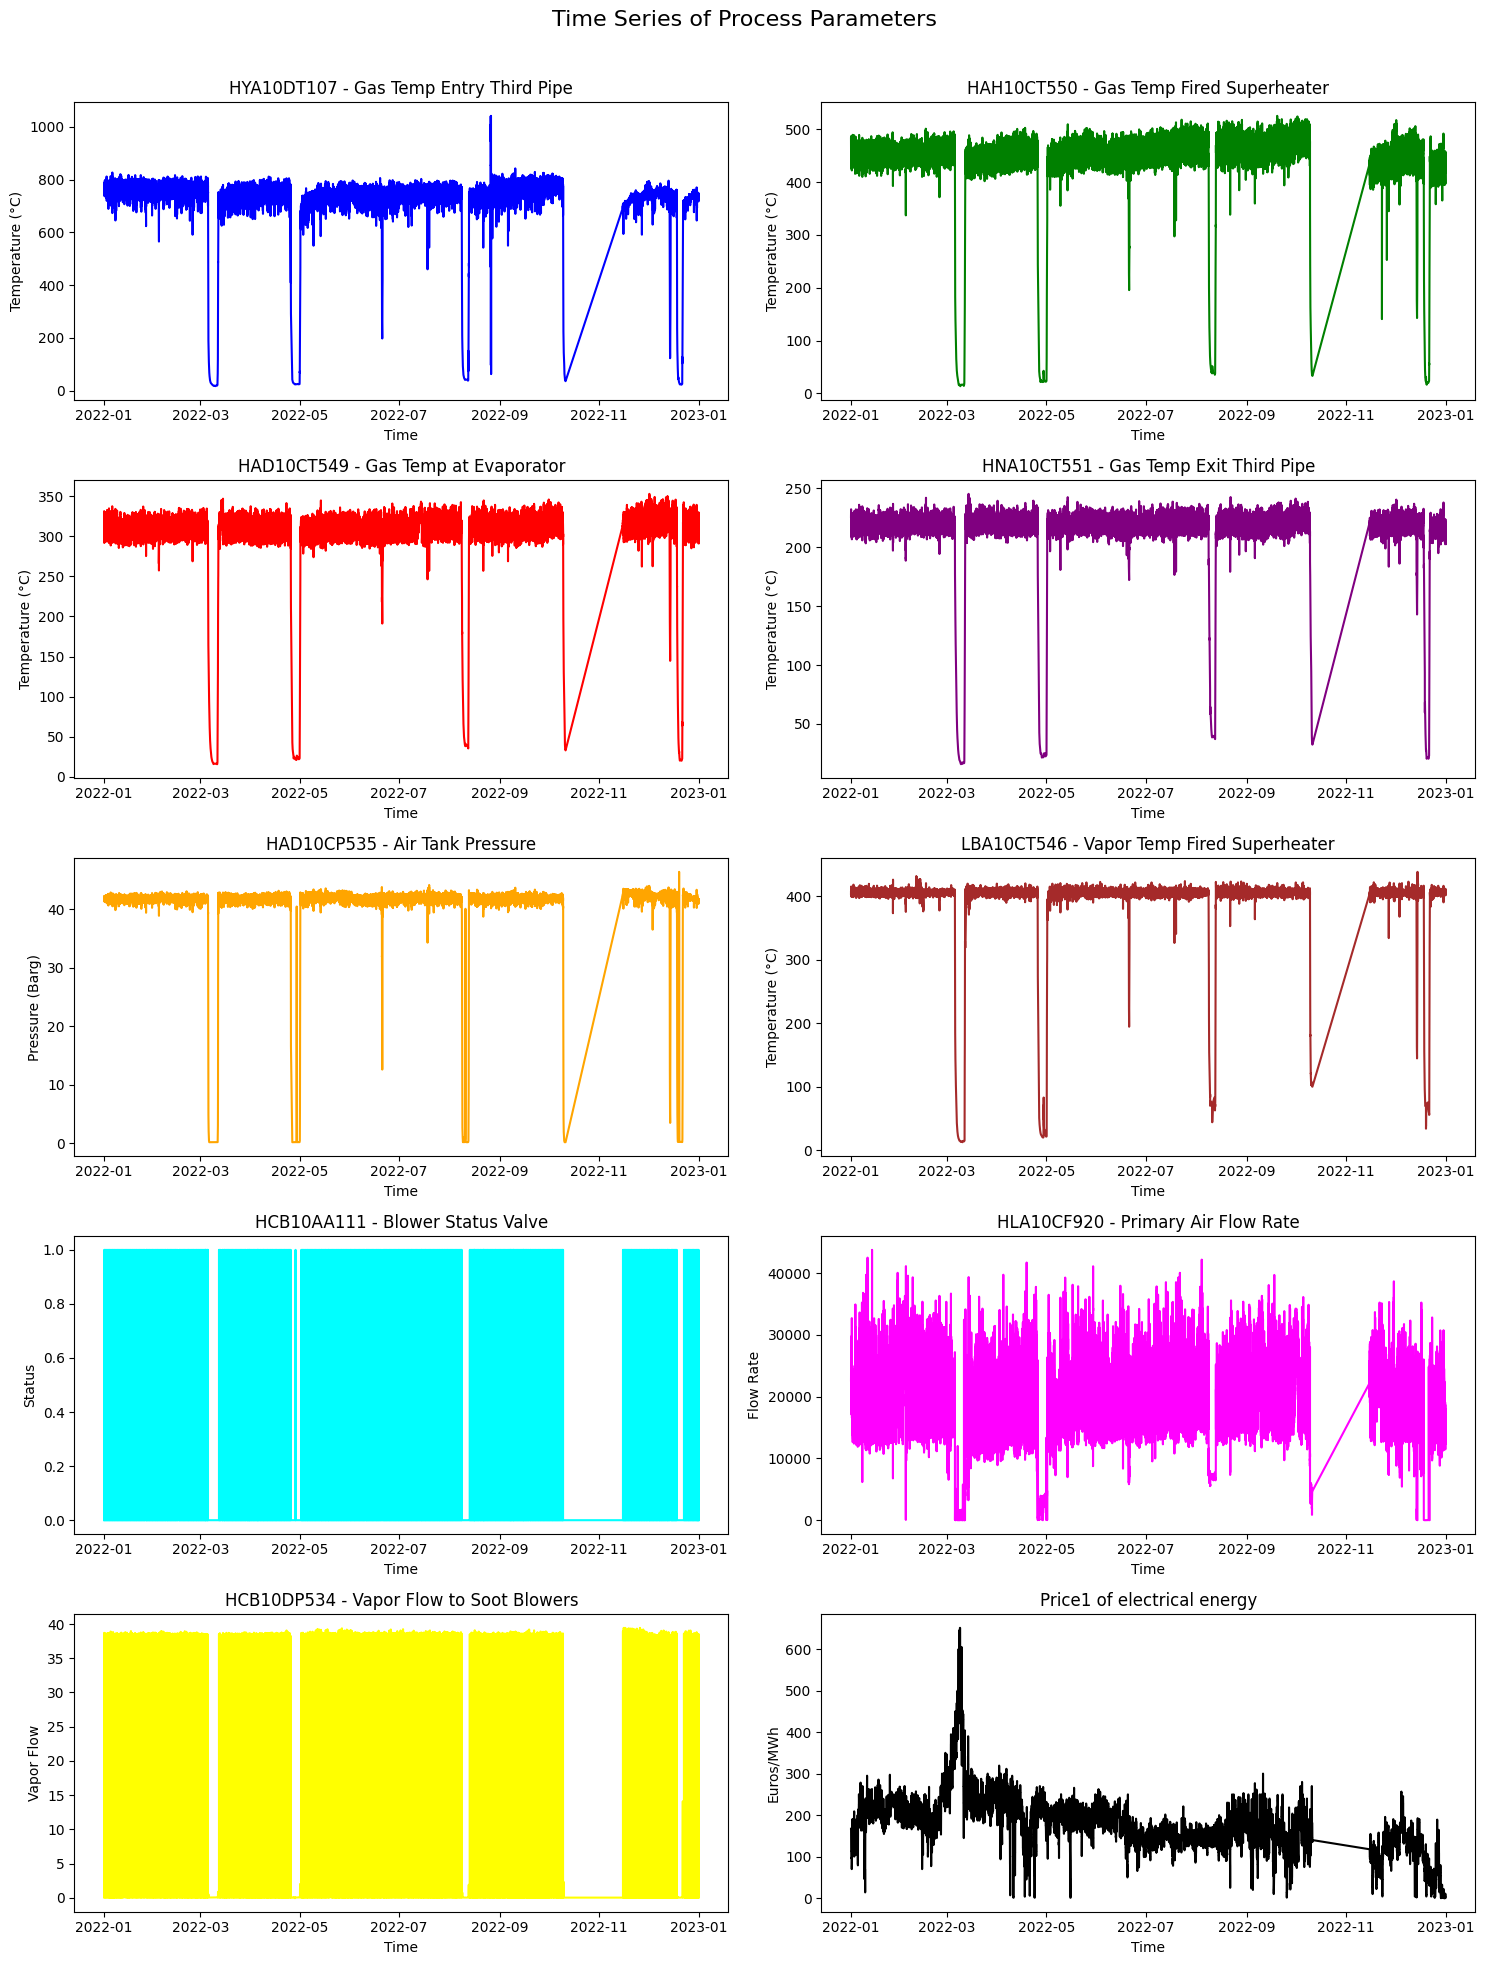

In [19]:
# Set up a figure for the subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Time Series of Process Parameters', fontsize=16)

# 1st subplot: HYA10DT107 Gas phase temperature at the entry of the third pipe sector
axs[0, 0].plot(merged_data['datetime'], merged_data['HYA10DT107'], color='blue')
axs[0, 0].set_title('HYA10DT107 - Gas Temp Entry Third Pipe')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Temperature (°C)')

# 2nd subplot: HAH10CT550 Gas phase temperature at the fired steam superheater
axs[0, 1].plot(merged_data['datetime'], merged_data['HAH10CT550'], color='green')
axs[0, 1].set_title('HAH10CT550 - Gas Temp Fired Superheater')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Temperature (°C)')

# 3rd subplot: HAD10CT549 Gas phase temperature at the evaporator
axs[1, 0].plot(merged_data['datetime'], merged_data['HAD10CT549'], color='red')
axs[1, 0].set_title('HAD10CT549 - Gas Temp at Evaporator')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Temperature (°C)')

# 4th subplot: HNA10CT551 Gas phase temperature at the exit of the third pipe sector
axs[1, 1].plot(merged_data['datetime'], merged_data['HNA10CT551'], color='purple')
axs[1, 1].set_title('HNA10CT551 - Gas Temp Exit Third Pipe')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Temperature (°C)')

# 5th subplot: HAD10CP535 System air tank pressure – Maintenance when lower than 39 Barg
axs[2, 0].plot(merged_data['datetime'], merged_data['HAD10CP535'], color='orange')
axs[2, 0].set_title('HAD10CP535 - Air Tank Pressure')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Pressure (Barg)')

# 6th subplot: LBA10CT546 Vapor phase temperature at the fired steam superheater
axs[2, 1].plot(merged_data['datetime'], merged_data['LBA10CT546'], color='brown')
axs[2, 1].set_title('LBA10CT546 - Vapor Temp Fired Superheater')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Temperature (°C)')

# 7th subplot: HCB10AA111 Blower status indicator valve
axs[3, 0].plot(merged_data['datetime'], merged_data['HCB10AA111'], color='cyan')
axs[3, 0].set_title('HCB10AA111 - Blower Status Valve')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Status')

# 8th subplot: HLA10CF920 Primary air flow rate
axs[3, 1].plot(merged_data['datetime'], merged_data['HLA10CF920'], color='magenta')
axs[3, 1].set_title('HLA10CF920 - Primary Air Flow Rate')
axs[3, 1].set_xlabel('Time')
axs[3, 1].set_ylabel('Flow Rate')

# 9th subplot: HCB10DP534 Vapor flow to soot blowers – Indicates when soot blowing is being performed
axs[4, 0].plot(merged_data['datetime'], merged_data['HCB10DP534'], color='yellow')
axs[4, 0].set_title('HCB10DP534 - Vapor Flow to Soot Blowers')
axs[4, 0].set_xlabel('Time')
axs[4, 0].set_ylabel('Vapor Flow')

# 10th subplot
axs[4, 1].plot(merged_data['datetime'], merged_data['price1'], color='black')
axs[4, 1].set_title('Price1 of electrical energy')
axs[4, 1].set_xlabel('Time')
axs[4, 1].set_ylabel('Euros/MWh')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

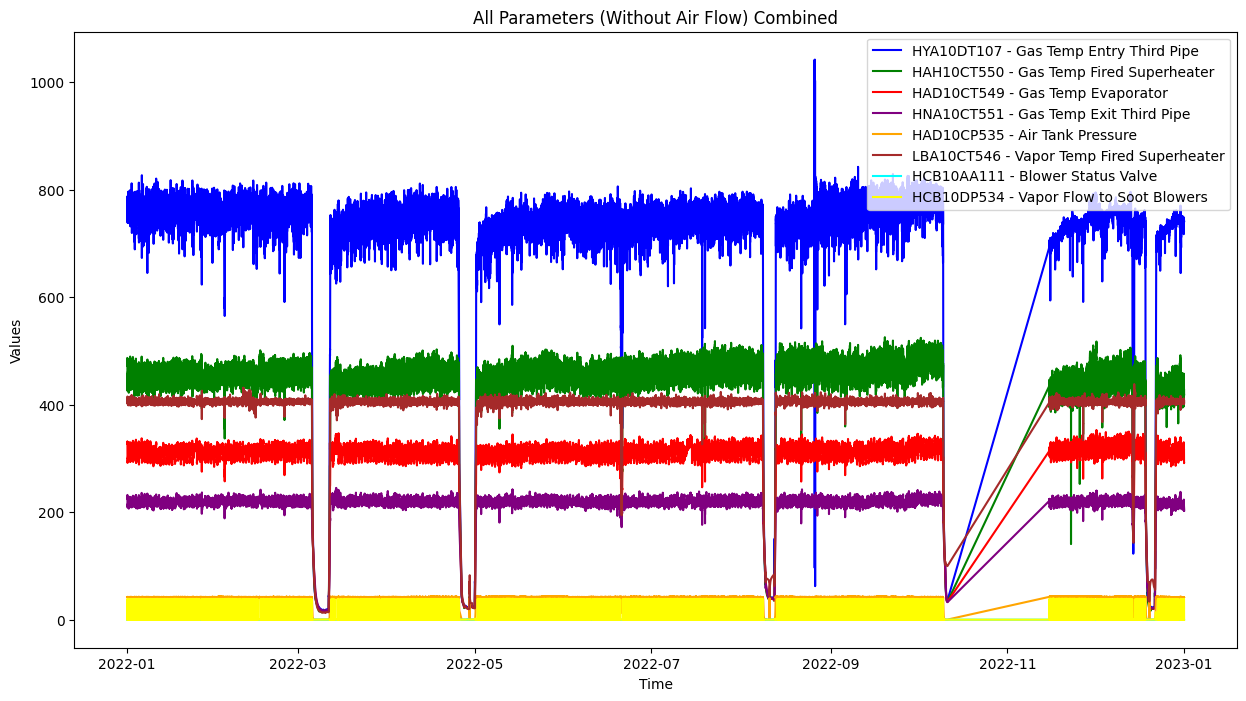

In [20]:
# Visualizing all the parameters
# for better readibility comment out price graph
plt.figure(figsize=(15, 8))
plt.plot(merged_data['datetime'], merged_data['HYA10DT107'], label='HYA10DT107 - Gas Temp Entry Third Pipe', color='blue')
plt.plot(merged_data['datetime'], merged_data['HAH10CT550'], label='HAH10CT550 - Gas Temp Fired Superheater', color='green')
plt.plot(merged_data['datetime'], merged_data['HAD10CT549'], label='HAD10CT549 - Gas Temp Evaporator', color='red')
plt.plot(merged_data['datetime'], merged_data['HNA10CT551'], label='HNA10CT551 - Gas Temp Exit Third Pipe', color='purple')
plt.plot(merged_data['datetime'], merged_data['HAD10CP535'], label='HAD10CP535 - Air Tank Pressure', color='orange')
plt.plot(merged_data['datetime'], merged_data['LBA10CT546'], label='LBA10CT546 - Vapor Temp Fired Superheater', color='brown')
plt.plot(merged_data['datetime'], merged_data['HCB10AA111'], label='HCB10AA111 - Blower Status Valve', color='cyan')
#plt.plot(merged_data['datetime'], merged_data['HLA10CF920'], label='HLA10CF920 - Primary Air Flow Rate', color='magenta')
plt.plot(merged_data['datetime'], merged_data['HCB10DP534'], label='HCB10DP534 - Vapor Flow to Soot Blowers', color='yellow')
#plt.plot(merged_data['datetime'], merged_data['price1'], label='price1 - Price1 of electrical energy', color='magenta')

# Labeling and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('All Parameters (Without Air Flow) Combined')
plt.legend(loc='upper right')
plt.show()

### Let's analyze the data in 72 hours

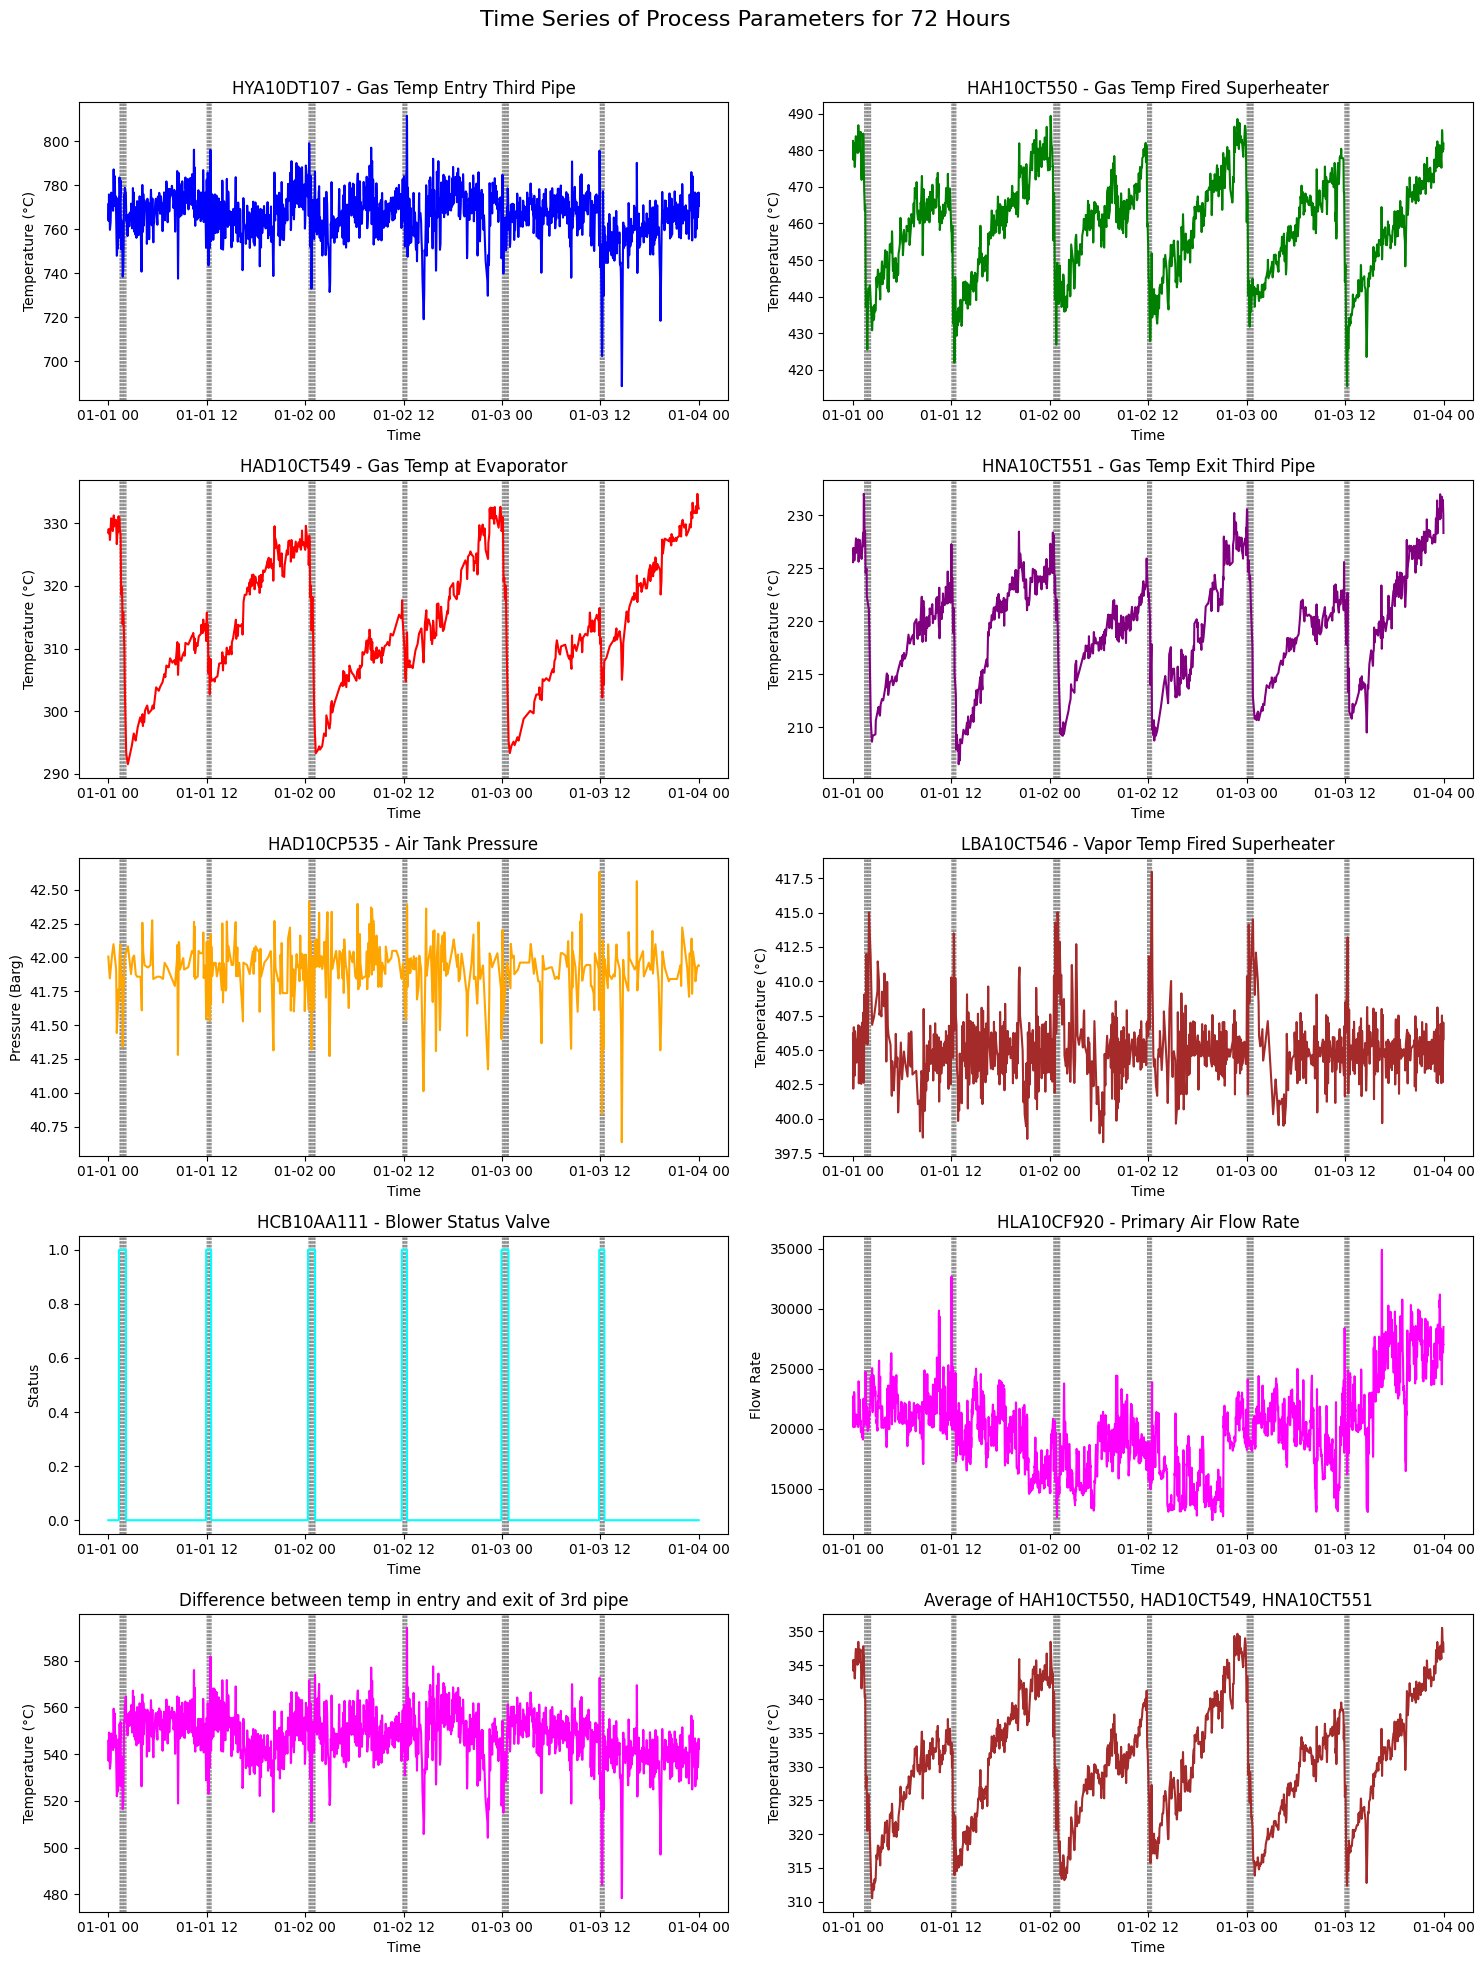

In [21]:
# Ensure 'datetime' column is in datetime format
merged_data['datetime'] = pd.to_datetime(merged_data['datetime'])

# Define the start and end times for the 24-hour window
start_time = '2022-01-01 00:00:00'  # Replace with the actual start time you want
end_time = '2022-01-03 23:59:59'    # End time 72 hours later

# Filter the data for the 24-hour window
filtered_data = merged_data[(merged_data['datetime'] >= start_time) & (merged_data['datetime'] <= end_time)]

# Set up a figure for the subplots for the filtered data
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Time Series of Process Parameters for 72 Hours', fontsize=16)

for idx, row in filtered_data.iterrows():
    if row['HCB10AA111'] == 1:
        # Vertical line in each subplot where relevant
        for ax in axs.flat:
            ax.axvline(x=row['datetime'], color='black', linestyle='--', alpha=0.1, linewidth=0.5)


# 1st subplot: HYA10DT107 Gas phase temperature at the entry of the third pipe sector
axs[0, 0].plot(filtered_data['datetime'], filtered_data['HYA10DT107'], color='blue')
axs[0, 0].set_title('HYA10DT107 - Gas Temp Entry Third Pipe')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Temperature (°C)')

# 2nd subplot: HAH10CT550 Gas phase temperature at the fired steam superheater
axs[0, 1].plot(filtered_data['datetime'], filtered_data['HAH10CT550'], color='green')
axs[0, 1].set_title('HAH10CT550 - Gas Temp Fired Superheater')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Temperature (°C)')

# 3rd subplot: HAD10CT549 Gas phase temperature at the evaporator
axs[1, 0].plot(filtered_data['datetime'], filtered_data['HAD10CT549'], color='red')
axs[1, 0].set_title('HAD10CT549 - Gas Temp at Evaporator')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Temperature (°C)')

# 4th subplot: HNA10CT551 Gas phase temperature at the exit of the third pipe sector
axs[1, 1].plot(filtered_data['datetime'], filtered_data['HNA10CT551'], color='purple')
axs[1, 1].set_title('HNA10CT551 - Gas Temp Exit Third Pipe')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Temperature (°C)')

# 5th subplot: HAD10CP535 System air tank pressure – Maintenance when lower than 39 Barg
axs[2, 0].plot(filtered_data['datetime'], filtered_data['HAD10CP535'], color='orange')
axs[2, 0].set_title('HAD10CP535 - Air Tank Pressure')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Pressure (Barg)')

# 6th subplot: LBA10CT546 Vapor phase temperature at the fired steam superheater
axs[2, 1].plot(filtered_data['datetime'], filtered_data['LBA10CT546'], color='brown')
axs[2, 1].set_title('LBA10CT546 - Vapor Temp Fired Superheater')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Temperature (°C)')

# 7th subplot: HCB10AA111 Blower status indicator valve
axs[3, 0].plot(filtered_data['datetime'], filtered_data['HCB10AA111'], color='cyan')
axs[3, 0].set_title('HCB10AA111 - Blower Status Valve')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Status')

# 8th subplot: HLA10CF920 Primary air flow rate
axs[3, 1].plot(filtered_data['datetime'], filtered_data['HLA10CF920'], color='magenta')
axs[3, 1].set_title('HLA10CF920 - Primary Air Flow Rate')
axs[3, 1].set_xlabel('Time')
axs[3, 1].set_ylabel('Flow Rate')

"""
# 9th subplot: HCB10DP534 Vapor flow to soot blowers – Indicates when soot blowing is being performed
axs[4, 0].plot(filtered_data['datetime'], filtered_data['HCB10DP534'], color='yellow')
axs[4, 0].set_title('HCB10DP534 - Vapor Flow to Soot Blowers')
axs[4, 0].set_xlabel('Time')
axs[4, 0].set_ylabel('Vapor Flow')
"""
axs[4, 0].plot(filtered_data['datetime'], filtered_data['Difference_entry_and_exit'], color='magenta')
axs[4, 0].set_title('Difference between temp in entry and exit of 3rd pipe')
axs[4, 0].set_xlabel('Time')
axs[4, 0].set_ylabel('Temperature (°C)')

# 10th subplot: Price of electrical energy
axs[4, 1].plot(filtered_data['datetime'], filtered_data['Average_Temperature'], color='brown')
axs[4, 1].set_title('Average of HAH10CT550, HAD10CT549, HNA10CT551')
axs[4, 1].set_xlabel('Time')
axs[4, 1].set_ylabel('Temperature (°C)')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

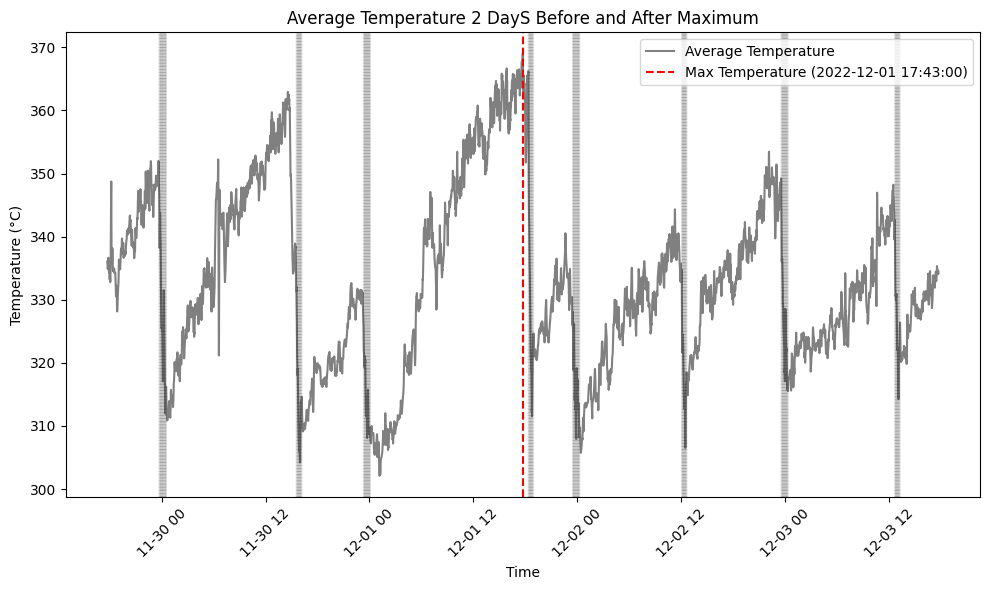

In [22]:
# 1. Find the index and datetime corresponding to the maximum value of Average_Temperature
max_idx = merged_data['Average_Temperature'].idxmax()
max_datetime = merged_data.loc[max_idx, 'datetime']
max_value = merged_data.loc[max_idx, 'Average_Temperature']

# 2. Define the time window (1 day before and 1 day after the maximum value)
start_time_max_value = max_datetime - pd.Timedelta(days=2)
end_time_max_value = max_datetime + pd.Timedelta(days=2)

# 3. Filter the data for the time window (1 day before and 1 day after max)
time_window_data = merged_data[(merged_data['datetime'] >= start_time_max_value) & (merged_data['datetime'] <= end_time_max_value)]

# 4. Plot Average_Temperature for this time window
plt.figure(figsize=(10, 6))
plt.plot(time_window_data['datetime'], time_window_data['Average_Temperature'], color='gray', label='Average Temperature')

# Mark the maximum point on the plot
plt.axvline(x=max_datetime, color='red', linestyle='--', label=f'Max Temperature ({max_datetime})')

for idx, row in time_window_data.iterrows():
    if row['HCB10AA111'] == 1:
        plt.axvline(x=row['datetime'], color='black', linestyle='--', alpha=0.2, linewidth = 0.2)

# Add labels and title
plt.title('Average Temperature 2 DayS Before and After Maximum')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


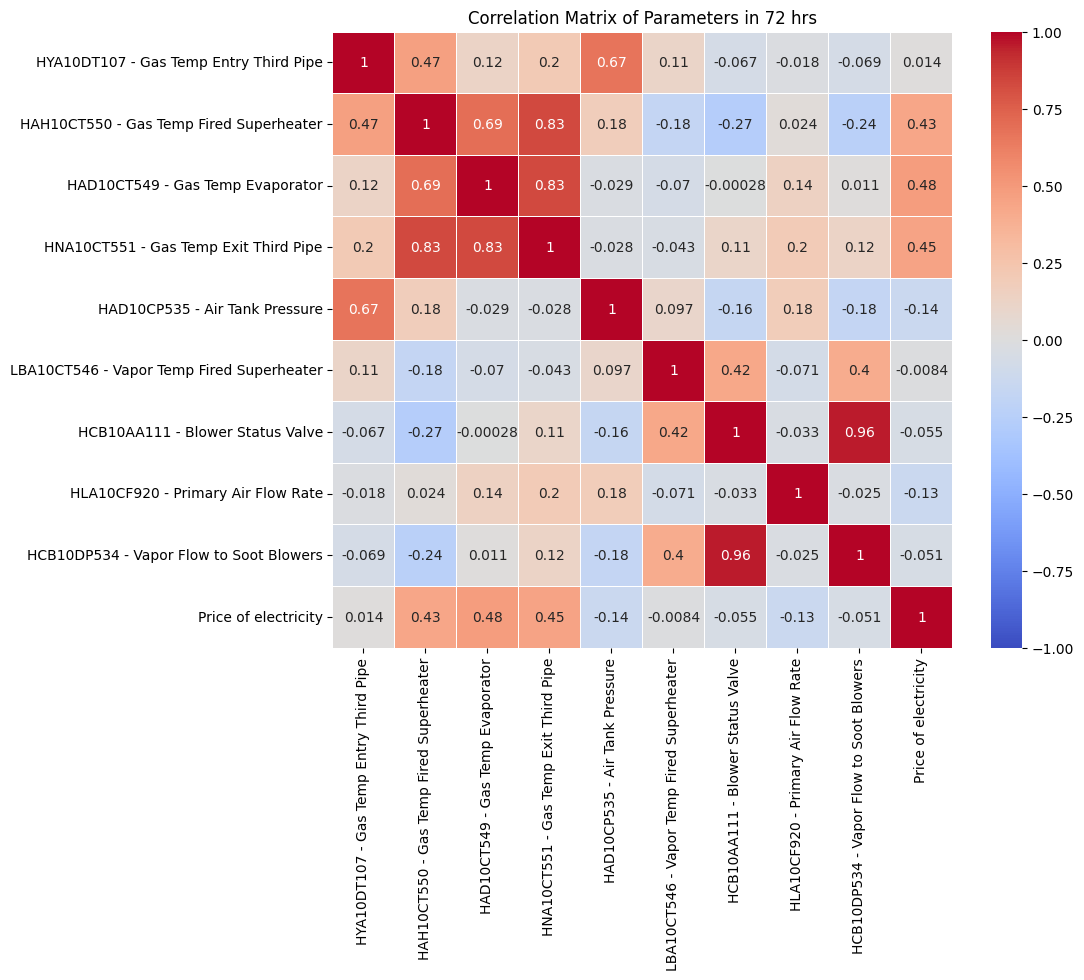

In [23]:
# Define the columns and their descriptive labels
columns_to_correlate = ['HYA10DT107', 'HAH10CT550', 'HAD10CT549', 'HNA10CT551', 
                        'HAD10CP535', 'LBA10CT546', 'HCB10AA111', 'HLA10CF920', 'HCB10DP534', 'price1']

descriptive_labels = [
    'HYA10DT107 - Gas Temp Entry Third Pipe',
    'HAH10CT550 - Gas Temp Fired Superheater',
    'HAD10CT549 - Gas Temp Evaporator',
    'HNA10CT551 - Gas Temp Exit Third Pipe',
    'HAD10CP535 - Air Tank Pressure',
    'LBA10CT546 - Vapor Temp Fired Superheater',
    'HCB10AA111 - Blower Status Valve',
    'HLA10CF920 - Primary Air Flow Rate',
    'HCB10DP534 - Vapor Flow to Soot Blowers',
    'Price of electricity'
]

# Generate the correlation matrix
correlation_matrix = filtered_data[columns_to_correlate].corr()

# Plot the correlation matrix with custom labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            xticklabels=descriptive_labels, yticklabels=descriptive_labels, linewidths=0.5)
plt.title('Correlation Matrix of Parameters in 72 hrs')
plt.show()


## Analysis
It seems like the soot is being blown twice a day, under a set schedule, not taking energy prices into consideration at all. 

The gas temperatures:
- <b>HAH10CT550</b>: Gas phase temperature at the fired steam superheater
- <b>HAD10CT549</b>: Gas phase temperature at the evaporator
- <b>HNA10CT551</b>: Gas phase temperature at the exit of the third pipe sector 

seem to be rising when as the pipes get dirtier, and drop when the soot is blown. It is not clear if <b>HYA10DT107</b>: Gas phase temperature at the entry of the third pipe sector gives an indication of how "dirty" the pipes are.

<b> These gas temperatures can give as a clear indication of how "dirty" the pipes are</b>

#### Goal:
The goal is to minimize the amount of soot blowing and delay or shift the soot blowing process to times when energy prices are lower, while still maintaining optimal system performance


#### TODO: 
- see if there are any other relevant inputs other than the gas temperatures and price of the electricity
- filter out the data when the plant is under maintenance (when the HAD10CP535 System air tank pressure is < 39 barg)
- what do we do with price1 and price2?
- make the model with the goal in mind
- evaluate the performance (compare the difference in cost of soot blowing, compare the frequency of cleaning, is it able to predict when soot blowing is required) 

### MAKING THE MODEL

#### Making a column for the values of the avarage temperatures 60 minutes in the future

In [24]:
merged_data = merged_data[merged_data['HCB10AA111'] != True]
merged_data.drop(columns=['HCB10AA111'], inplace=True)

# Shift the target column (Sensor_Mean) by 60 minutes (assuming data is at regular time intervals)
merged_data['Average_Temperature_60min_Future'] = merged_data['Average_Temperature'].shift(-60)

# Drop rows with NaN values created by the shift
merged_data.dropna(subset=['Average_Temperature_60min_Future'], inplace=True)


In [25]:
# Define the input features (all sensors data) and the target (mean of sensors 60 minutes in the future)
X = merged_data[['HYA10DT107', 'HAH10CT550', 'HAD10CT549', 'HNA10CT551', 'HAD10CP535', 'LBA10CT546', 'HLA10CF920']]
y = merged_data['Average_Temperature_60min_Future']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
# Initialize and train the XGBoost Regressor
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

Mean Squared Error: 162.4521
RMSE: 12.74566866368848


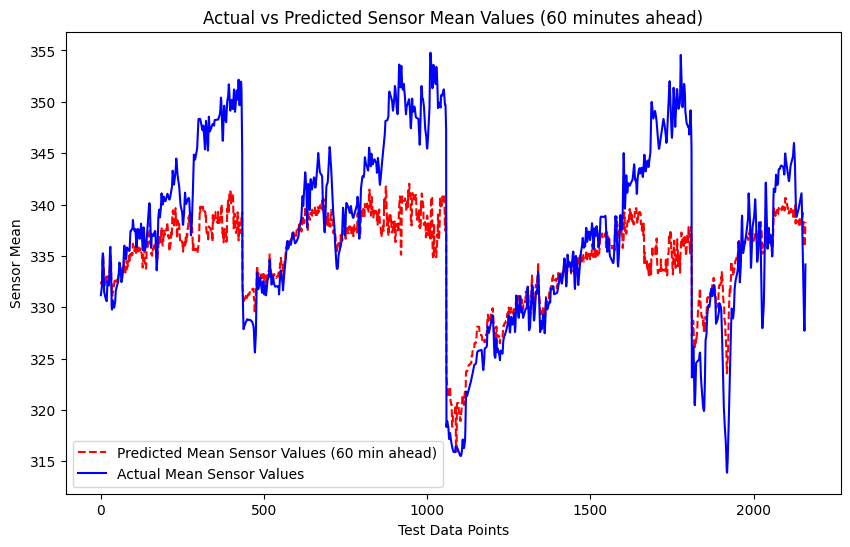

In [27]:
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Define the number of points you want to plot
start_points = 720*4
end_points = start_points + 720*3

actual_current = X_test[['HAH10CT550', 'HAD10CT549', 'HNA10CT551']].mean(axis=1)  # Assuming average temperature of the current values
actual_current = actual_current.values[start_points:end_points]
# Slice the data to include only the first `num_points`
y_test_subset = y_test.values[start_points:end_points]
y_pred_subset = y_pred[start_points:end_points]
#y_test_subset = y_test_merged_data[start_points:end_points]

#print(y_pred_subset)
# Plot the subset of the data
plt.figure(figsize=(10, 6))
#plt.plot(y_test_subset, label='Actual Mean Sensor Values (60 min ahead)', color='blue')
plt.plot(y_pred_subset, label='Predicted Mean Sensor Values (60 min ahead)', color='red', linestyle='--')
plt.plot(actual_current, label='Actual Mean Sensor Values', color='blue')
plt.xlabel('Test Data Points')
plt.ylabel('Sensor Mean')
plt.title('Actual vs Predicted Sensor Mean Values (60 minutes ahead)')
plt.legend()
plt.show()

### XGBOOST with lag 

In [ ]:
# Assuming 'merged_data' contains the relevant sensor data and timestamps
data = merged_data.copy()

# Create lag features for each sensor column (from 1 to 60 minutes ago)
for lag in range(1, 60):
    data[f'HYA10DT107_lag{lag}'] = data['HYA10DT107'].shift(lag)
    data[f'HAH10CT550_lag{lag}'] = data['HAH10CT550'].shift(lag)
    data[f'HAD10CT549_lag{lag}'] = data['HAD10CT549'].shift(lag)
    data[f'HNA10CT551_lag{lag}'] = data['HNA10CT551'].shift(lag)
    data[f'HAD10CP535_lag{lag}'] = data['HAD10CP535'].shift(lag)
    data[f'LBA10CT546_lag{lag}'] = data['LBA10CT546'].shift(lag)
    data[f'HLA10CF920_lag{lag}'] = data['HLA10CF920'].shift(lag)


# Drop rows with NaN values created by the shift (only the first 60 rows will be NaN)
data.dropna(inplace=True)

# Define the input features (using all 60 lags) and the target variable (e.g., future sensor mean)
lag_features = [col for col in data.columns if 'lag' in col]
X = data[['HYA10DT107', 'HAH10CT550', 'HAD10CT549', 'HNA10CT551', 'HAD10CP535', 'LBA10CT546', 'HLA10CF920'] + lag_features]
y = data['Average_Temperature_60min_Future']  # Assuming you have this target from previous steps


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the XGBoost Regressor
xgbr = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgbr.fit(X_train, y_train)

# Make predictions
y_pred = xgbr.predict(X_test)


Mean Squared Error: 168.8625
RMSE: 12.994711461198674


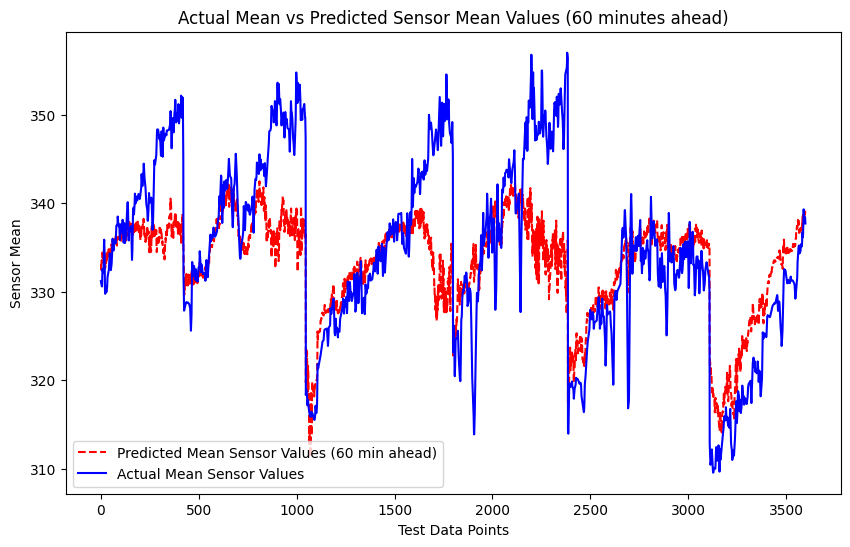

In [30]:
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Define the number of points you want to plot
start_points = 720*4
end_points = start_points + 720*5

actual_current = X_test[['HAH10CT550', 'HAD10CT549', 'HNA10CT551']].mean(axis=1)  # Assuming average temperature of the current values
actual_current = actual_current.values[start_points:end_points]
# Slice the data to include only the first `num_points`
y_test_subset = y_test.values[start_points:end_points]
y_pred_subset = y_pred[start_points:end_points]
#y_test_subset = y_test_merged_data[start_points:end_points]

#print(y_pred_subset)
# Plot the subset of the data
plt.figure(figsize=(10, 6))
#plt.plot(y_test_subset, label='Actual Mean Sensor Values (60 min ahead)', color='blue')
plt.plot(y_pred_subset, label='Predicted Mean Sensor Values (60 min ahead)', color='red', linestyle='--')
plt.plot(actual_current, label='Actual Mean Sensor Values', color='blue')
plt.xlabel('Test Data Points')
plt.ylabel('Sensor Mean')
plt.title('Actual Mean vs Predicted Sensor Mean Values (60 minutes ahead)')
plt.legend()
plt.show()

In [ ]:
# Initialize and train the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbr_model.predict(X_test)

Mean Squared Error: 156.3075
RMSE: 12.502298186934851


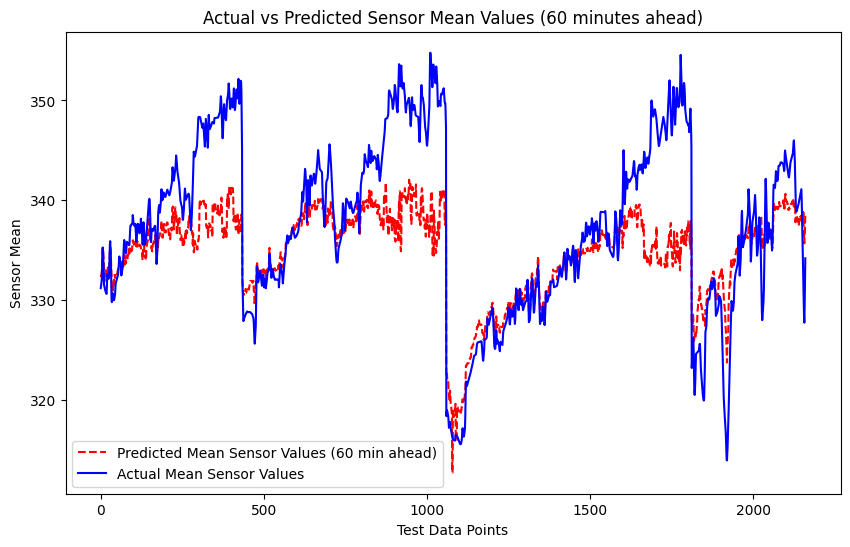

In [ ]:
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Define the number of points you want to plot
start_points = 720*4
end_points = start_points + 720*3

actual_current = X_test[['HAH10CT550', 'HAD10CT549', 'HNA10CT551']].mean(axis=1)  # Assuming average temperature of the current values
actual_current = actual_current.values[start_points:end_points]
# Slice the data to include only the first `num_points`
y_test_subset = y_test.values[start_points:end_points]
y_pred_subset = y_pred[start_points:end_points]
#y_test_subset = y_test_merged_data[start_points:end_points]

#print(y_pred_subset)
# Plot the subset of the data
plt.figure(figsize=(10, 6))
#plt.plot(y_test_subset, label='Actual Mean Sensor Values (60 min ahead)', color='blue')
plt.plot(y_pred_subset, label='Predicted Mean Sensor Values (60 min ahead)', color='red', linestyle='--')
plt.plot(actual_current, label='Actual Mean Sensor Values', color='blue')
plt.xlabel('Test Data Points')
plt.ylabel('Sensor Mean')
plt.title('Actual vs Predicted Sensor Mean Values (60 minutes ahead)')
plt.legend()
plt.show()